In [1]:
import matplotlib.pyplot as plt
import os, sys
import netCDF4
from utils.MCGO_Analysis import MCGO_Post_Process
import numpy as np

In [2]:
mcgo_nc_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/NSTX_FOW_RF_NBIreinj_run29d_dt0014_reinj100ms_promptIncluded_ivlim30.nc'
eqdsk_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/eqdsk_t217ms'

# create the pp object

mcgo_pp = MCGO_Post_Process(mcgo_nc_file=mcgo_nc_file, eqdsk_file=eqdsk_file, particle_lists_on=True)



['  500  500\n']


Rmin:  0.185200005
Rmax:  1.57100006


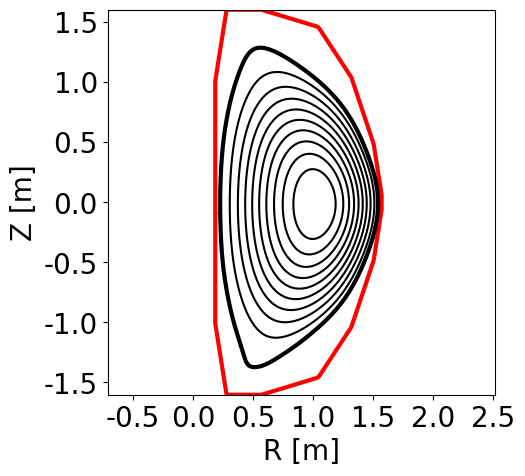

In [3]:
print('Rmin: ', np.min(mcgo_pp.eqdsk['rlim']))
print('Rmax: ', np.max(mcgo_pp.eqdsk['rlim']))
mcgo_pp.plot_equilibrium(figsize=(5,5), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1])

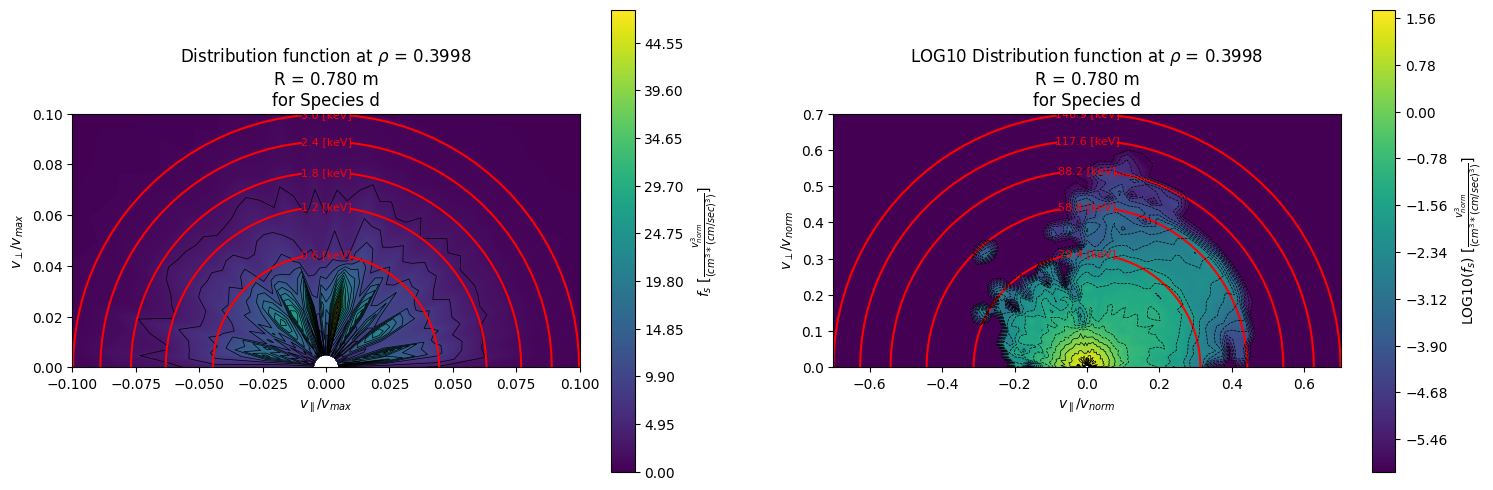

In [4]:
# try out plotting
rho_idx = 8
mcgo_pp.plot_distribution_function_at_rho(
        rho_index=rho_idx,
        v_norm_over_v_max=0.1,
        log_scale_axis_multiple=7,
        log_clip_level=1e-6,
        figsize=(18, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=None,
        energy_levels_log=None,
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

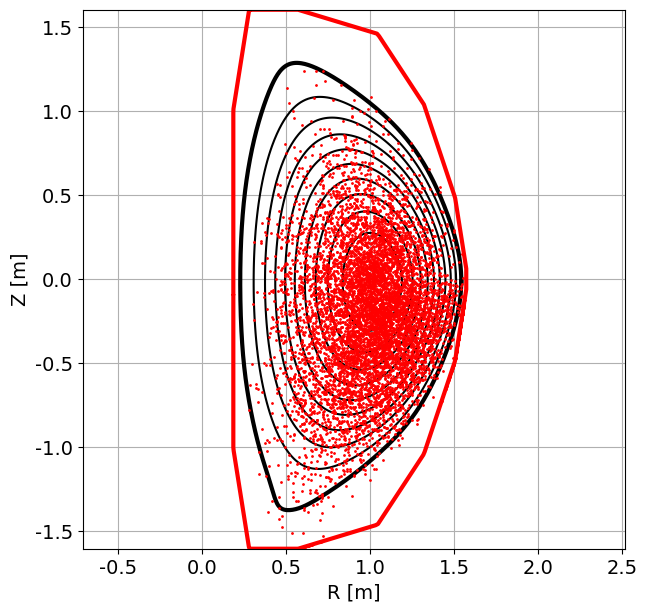

In [5]:
mcgo_pp.plot_particle_end_RZ(figsize=(7,7), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1], fontsize=14, dotsize=2, return_plot=False)

In [6]:
# test input deck editor
infile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/mcgoinput'
outfile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/mcgoinput_out2'

updates = {'mf': [120],
           'rte': [1e5]*100,
           'rni(1,1)': [2e5]*100} 

mcgo_pp.update_fortran_input_deck_full(input_file=infile, updates=updates, out_file=outfile)

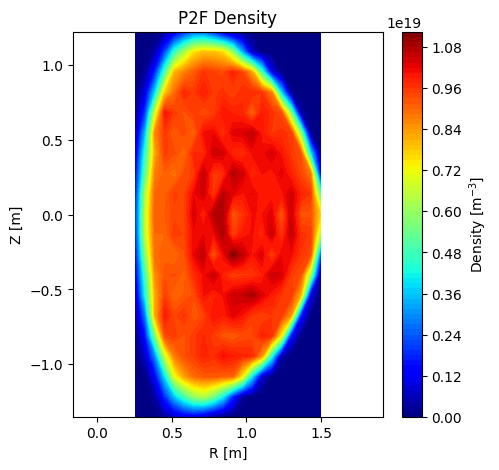

In [7]:
# p2f functionality 
p2f_out_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/fdis.dav.nc'

mcgo_pp.load_p2f_output(p2f_out_file=p2f_out_file)
mcgo_pp.p2f_plot_density_RZ(figsize=(6,6))

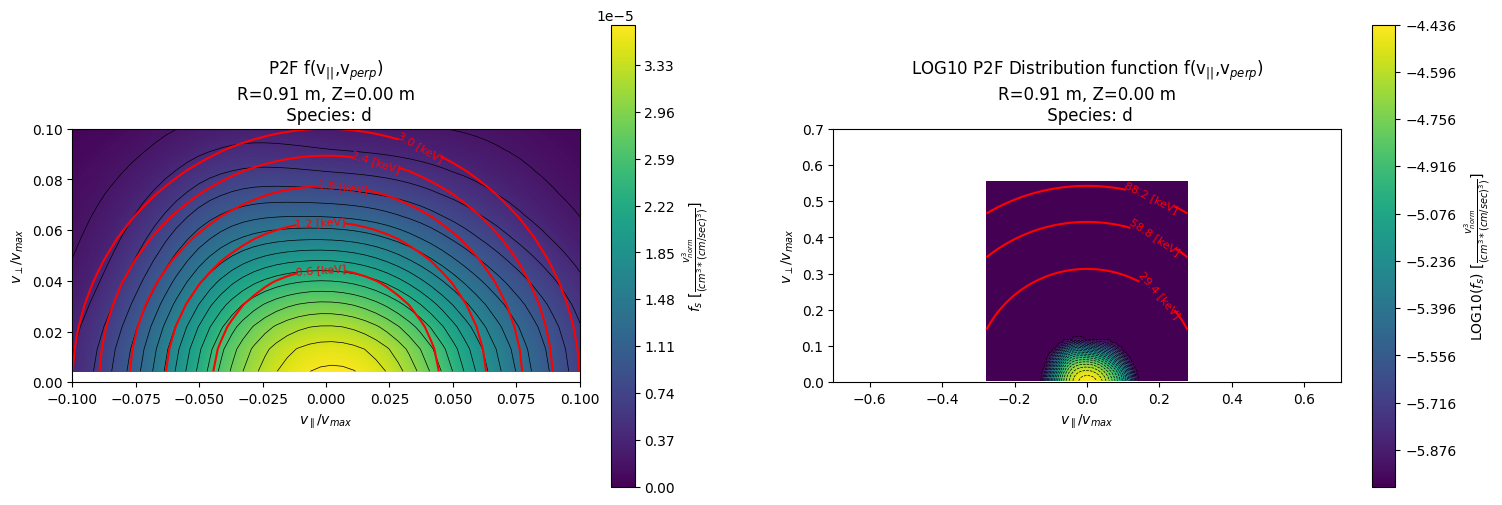

In [18]:
rho_idx = 8
iR = 10
iZ = 10
mcgo_pp.p2f_plot_distribution_function_at_RZ(
        R_index=iR,
        Z_index=iZ,
        v_norm_over_v_max=0.1,
        log_scale_axis_multiple=7,
        log_clip_level=1e-6,
        figsize=(18, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=None,
        energy_levels_log=None,
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

In [9]:
# testing editor function 
import re
from typing import List, Dict, Union

def update_fortran_input_deck_full(
    input_file: str,
    updates: Dict[str, Union[List[float], List[str], str, float]],
    out_file: str
):
    # Load the deck from file
    with open(input_file, "r") as f:
        input_lines = f.readlines()

    output_lines = []
    i = 0

    while i < len(input_lines):
        line = input_lines[i].rstrip()
        leading_spaces = re.match(r"^(\s*)", line).group(1)

        # Indexed numeric variable (e.g., rni(1,3)=...)
        # indexed_match = re.match(r"^(\w+\(\d+,\d+\))\s*=", line.lstrip())
        # print(indexed_match)
        # if indexed_match:
        #     full_key = indexed_match.group(1)
        #     if full_key in updates:
        #         values = updates[full_key]
        #         formatted = ' '.join(f"{v:.6E}" for v in values)
        #         output_lines.append(leading_spaces + f"{full_key}= {formatted}\n")
        #         i += 1
        #         while i < len(input_lines) and not re.match(r"^\w+", input_lines[i].strip()):
        #             i += 1
        #         continue
        indexed_match = re.match(r"^(\s*)(\w+\(\d+,\d+\))\s*=", line)
        if indexed_match:
            leading_ws, full_key = indexed_match.groups()
            if full_key in updates:
                values = updates[full_key]
                chunk_size = 5
                chunks = [
                    leading_ws + '   ' + '   '.join(f"{v:.6E}" for v in values[i:i+chunk_size]) + '\n'
                    for i in range(0, len(values), chunk_size)
                ]
                # First line uses the assignment
                output_lines.append(f"{leading_ws}{full_key}= {chunks[0].lstrip()}")
                output_lines.extend(chunks[1:])
                i += 1
                assignment_start = re.compile(r"^\s*\w+(\([^\)]*\))?\s*=")
                while i < len(input_lines) and not assignment_start.match(input_lines[i]):
                    i += 1
                continue
            
        # Match varname = value [! comment]
        block_match = re.match(r"^(\w+)\s*=\s*([^!]*)(!?)(.*)", line.lstrip())
        if block_match:
            varname, existing_value, exclam, comment = block_match.groups()
            if varname in updates:
                new_value = updates[varname]
                comment_part = f" {exclam}{comment}" if exclam else ""

                # Handle string or list-of-strings
                if isinstance(new_value, str):
                    output_lines.append(leading_spaces + f"{varname}= '{new_value}'{comment_part}\n")
                elif isinstance(new_value, list) and all(isinstance(v, str) for v in new_value):
                    joined = ','.join(f"'{v}'" for v in new_value)
                    output_lines.append(leading_spaces + f"{varname}= {joined}{comment_part}\n")
                elif isinstance(new_value, list) and len(new_value) > 1:
                    # Float block array (e.g., te)
                    chunk_size = 5
                    chunks = [
                        '   ' + '   '.join(f"{v:.6E}" for v in new_value[i:i+chunk_size]) + '\n'
                        for i in range(0, len(new_value), chunk_size)
                    ]
                    output_lines.append(leading_spaces + f"{varname}= {chunks[0].strip()}\n")
                    output_lines.extend(chunks[1:])
                else:
                    # Single float
                    val = new_value[0] if isinstance(new_value, list) else new_value
                    output_lines.append(leading_spaces + f"{varname}= {val}{comment_part}\n")

                i += 1
                while i < len(input_lines) and re.match(r"^\s*[\d.Ee\+\-\*]+", input_lines[i].strip()):
                    i += 1
                continue

        # Default: preserve original
        output_lines.append(input_lines[i])
        i += 1

    # Save to a new file
    with open(out_file, "w") as f:
         f.writelines(output_lines)

    # return output_lines



In [10]:
infile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/mcgoinput'
outfile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/MCGO/run29d_dt0/mcgoinput_out'

updates = {'mf': [120],
           'rte': [1e5]*100,
           'rni(1,1)': [2e5]*100}

update_fortran_input_deck_full(input_file=infile, updates=updates, out_file=outfile)

In [11]:
# testing TODO delete once implimented into the class
mcgo_nc = netCDF4.Dataset(mcgo_nc_file, "r")


In [12]:
print(mcgo_nc.variables.keys())
c = 3e8 # m/s
pitch_angle_grid = mcgo_nc.variables['ptchbnd'][:]
velocity_grid =  mcgo_nc.variables['vbnd'][:]
vdstb = mcgo_nc.variables['vdstb'][:]
# print(pitch_angle_grid)
print(velocity_grid)

cosy=np.asmatrix(np.cos(pitch_angle_grid)) #make a matrix (1,iptchbnd) {not same as vector}
#cosy=cosy.transpose()          # transpose to (iptchbnd,1) shape
siny=np.asmatrix(np.sin(pitch_angle_grid)) #make a matrix (1,iptchbnd) {not same as vector}
#siny=siny.transpose()          # transpose to (iptchbnd,1) shape
xx=np.asmatrix(velocity_grid).T # make a matrix (1,ivbnd)   [m/s]
# X=np.dot(cosy,xx)    # (iptchbnd,ivbnd) matrix
# Y=np.dot(siny,xx)    # (iptchbnd,ivbnd) matrix
X=np.dot(xx, cosy)    # (iptchbnd,ivbnd) matrix
Y=np.dot(xx, siny)    # (iptchbnd,ivbnd) matrix
r_index = 8


fdist= vdstb[r_index,:,:]#.transpose()

fdistlog10 = np.log10(np.clip(fdist, 1e-6, None))
#fdistlog10 = np.nan_to_num(np.log10(fdist))
print(X.shape)
print(fdistlog10.shape)


dict_keys(['version', 'mnemonic', 'eqdskin', 'raxis', 'zaxis', 'xlimiter', 'ylimiter', 'rcontr', 'zcontr', 'nparts_tot', 'mf', 'rhobincent', 'rps_bincent', 'npol_start', 'irbnd', 'ivbnd', 'iptchbnd', 'ptchbnd', 'vbnd', 'radbnd', 'psibin', 'rho_sqpolflx', 'vdstb', 'rst', 'zst', 'rend', 'zend', 'vparend', 'vperend', 'ivparini'])
[  25896.354  130507.3    235118.23   339729.2    444340.12   548951.06
  653562.     758172.94   862783.9    967394.8   1072005.8   1176616.8
 1281227.6   1385838.6   1490449.5   1595060.5   1699671.4   1804282.4
 1908893.2   2013504.2   2118115.2   2222726.    2327337.    2431948.
 2536559.    2641170.    2745780.8   2850391.8   2955002.8   3059613.8
 3164224.5   3268835.5   3373446.5   3478057.5   3582668.2   3687279.2
 3791890.2   3896501.2   4001112.    4105723.    4210334.    4314945.
 4419556.    4524167.    4628778.    4733388.5   4837999.5   4942610.5
 5047221.5   5151832.5   5256443.5   5361054.5  ]
(52, 51)
(52, 51)


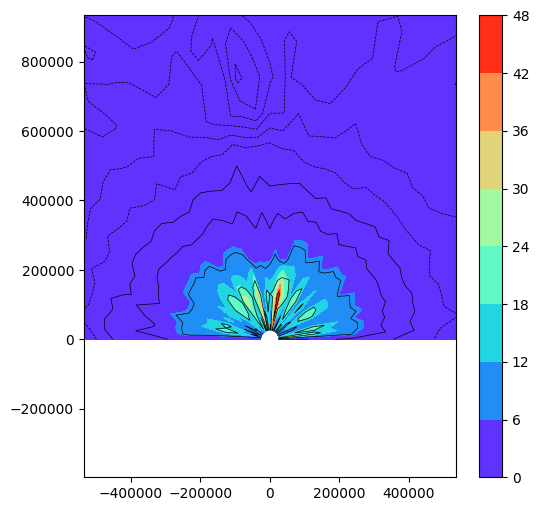

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
cf = ax.contourf(X,Y,fdist, cmap='rainbow')
ax.contour(X,Y,fdistlog10, levels=20, colors='black', linewidths=0.5)
lim = 0.1*np.max(velocity_grid)
ax.axis('equal')
ax.set_xlim(-lim, lim)
ax.set_ylim(0, lim)
fig.colorbar(cf)



In [34]:
# TESTING OUT PARTICLE LISTS
rend= mcgo_nc.variables['rend'] #[m] R-coord at t=tend
zend= mcgo_nc.variables['zend'] #[m] Z-coord at t=tend
rend=np.asarray(rend)
zend=np.asarray(zend)
vparend= mcgo_nc.variables['vparend'] #[m/s] Vpar at t=tend
vperend= mcgo_nc.variables['vperend'] #[m/s] Vper at t=tend
vparend=np.asarray(vparend)
vperend=np.asarray(vperend)
ivparini= mcgo_nc.variables['ivparini'] #sign of Vpar at t=0
ivparini=np.asarray(ivparini) # +1 or -1

print(np.min(vparend))
print(vperend.shape)



-1281784.8
(7933,)


In [31]:
# creat a function that saves the end particle list to a new .nc file 
def save_particles_to_p2f_style_nc(filename, r, z, vperp, vpar, weight):
    """
    Save 1D arrays of particle data to a NetCDF file for use with p2f.

    Parameters
    ----------
    filename : str
        Output path to NetCDF file (e.g., "particles.nc").
    r, z, vperp, vpar, weight : 1D numpy arrays
        Particle data arrays of equal length.
    """
    assert all(len(arr) == len(r) for arr in [z, vperp, vpar, weight]), "All input arrays must be the same length"
    nP = len(r)

    with netCDF4.Dataset(filename, "w", format="NETCDF4") as nc:
        # Define the dimension
        nc.createDimension("nP", nP)

        # Create variables
        r_var      = nc.createVariable("r", "f4", ("nP",))
        z_var      = nc.createVariable("z", "f4", ("nP",))
        vperp_var  = nc.createVariable("vperp", "f4", ("nP",))
        vpar_var   = nc.createVariable("vpar", "f4", ("nP",))
        weight_var = nc.createVariable("weight", "f4", ("nP",))

        # Write data
        r_var[:]      = r
        z_var[:]      = z
        vperp_var[:]  = vperp
        vpar_var[:]   = vpar
        weight_var[:] = weight

        # Optional: add metadata
        nc.title = "Particle list for p2f"
        nc.description = "Generated from Python"
        nc.nP = nP

In [35]:
# test out this functionality 
p2f_infile = 'p2f_particle_list_in_test_nstx.nc'
rend= mcgo_nc.variables['rend'][:] #[m] R-coord at t=tend
zend= mcgo_nc.variables['zend'][:] #[m] Z-coord at t=tend
rend=np.asarray(rend)
zend=np.asarray(zend)
vparend= mcgo_nc.variables['vparend'][:] #[m/s] Vpar at t=tend
vperend= mcgo_nc.variables['vperend'][:] #[m/s] Vper at t=tend
weights = np.ones_like(rend)
save_particles_to_p2f_style_nc(filename=p2f_infile, r=rend, z=zend, vperp=vperend, vpar=vparend, weight=weights)

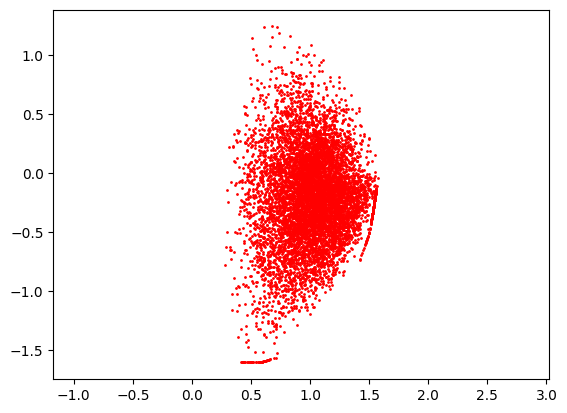

In [15]:
dot_size = 2
plt.axis('equal')
kp=np.where(ivparini>0) # RED:  Vpar>0 at t=0
kn=np.where(ivparini<0) # BLUE: Vpar<0 at t=0
plt.plot(rend[kp],zend[kp],'r.',markersize=dot_size)  #Large arrays; consider stride
plt.plot(rend[kn],zend[kn],'b.',markersize=dot_size)  #Large arrays; consider stride